Building the model:

Our model is constructed using the Modelbase software. For that, a dictionary including the parameters is created and passed to the model object. After declaring the compounds of the model, all reactions are introduced using corresponding stoichiometries and functions representing their rate equations.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import scipy.optimize
from modelbase.ode import Model, LabelModel, LinearLabelModel, Simulator, mca




#Defining the parameterset

defP = {'SL_D14_TO': 4.86439696e+00,#0.005
                     
         'SL_SMXL6_TO':2.47686667e+01,
            
         
         'SL_eff': 3.18236927e-01,
         
         
         'SL_ka':1.00057740e+01,
        
         'SL_lm': 3.08892044e-01,
 
        
        'recycle':1.00000000e-03,#0.03

         'SL_inf': 0.000} 




#initiating the model object


m = Model()
m.add_parameters(defP)


#adding compound IDs

m.add_compounds(['SL','D14','SMXL6','SL_D14'])

#adding all reactions


def SL_Influx(SL_inf):

    return SL_inf



m.add_reaction(
    rate_name="SL_Influx",
    function=SL_Influx,
    stoichiometry=({'SL':1}),
    parameters=["SL_inf"],
)



def SL_Efflux(SL,SL_eff):
    return SL_eff*SL

m.add_reaction(
    rate_name="SL_Efflux",
    function=SL_Efflux,
    stoichiometry=({'SL':-1}),
    parameters=["SL_eff"],
)




def SL_ka(SL,D14,SL_ka):
    return SL_ka*(SL*D14)


m.add_reaction(
    rate_name="SL_ka",
    function=SL_ka,
    stoichiometry=({'SL':-1,'D14':-1,'SL_D14':1}),
    parameters=["SL_ka"],
)


def SLlm(SL_D14,SMXL6,SL_lm):
    return (SL_D14*SMXL6*SL_lm)


m.add_reaction(
    rate_name="SL_lm",
    function=SLlm,
    modifiers=['SL_D14'],
    stoichiometry=({'SMXL6':-1}),
    parameters=["SL_lm"],
)


def D14_recycle(SL_D14,recycle):
    return SL_D14 * recycle
          
    
m.add_reaction(
    rate_name="D14_recycle",
    function=D14_recycle,
    stoichiometry=({'D14':1,'SL_D14':-1}),
    parameters=["recycle"],
)

    
def SMXL6_Influx(SL_SMXL6_TO):
    return SL_SMXL6_TO


m.add_reaction(
    rate_name="SMXL6_Influx",
    function=SMXL6_Influx,
    stoichiometry=({'SMXL6':1}),
    parameters=["SL_SMXL6_TO"],
)



def SMXL6_Efflux(SMXL6,SL_SMXL6_TO):
    return SL_SMXL6_TO*SMXL6


m.add_reaction(
    rate_name="SMXL6_Efflux",
    function=SMXL6_Efflux,
    stoichiometry=({'SMXL6':-1}),
    parameters=["SL_SMXL6_TO"],
)

def D14_Influx(SL_D14_TO):
    return SL_D14_TO


m.add_reaction(
    rate_name="D14_Influx",
    function=D14_Influx,
    stoichiometry=({'D14':1}),
    parameters=["SL_D14_TO"],
)


def D14_Efflux(D14,SL_D14_TO):
    return SL_D14_TO*D14

 
m.add_reaction(
    rate_name="D14_Efflux",
    function=D14_Efflux,
    stoichiometry=({'D14':-1}),
    parameters=["SL_D14_TO"],
)

Could not find GLIMDA.


All experimental data for SMXL6 and D14 abundance over time ist packed into lists for later use.

In [2]:
#lists of SMXL6 data

conc=[[1.00,	1.02,	0.99,	0.88,	0.61,	0.50],[1.00,	0.94	,0.93,	0.73,	0.52	,0.36],[1.00	,0.94,	0.96	,0.69	,0.43	,0.25],[1.00,	0.97	,0.78,	0.62,	0.32,	0.20],[1.00, 0.93 ,0.69, 0.45 ,0.28 ,0.11],[1.00,	0.80	,0.48,	0.17	,0.09,	0.07],[1.00 ,0.82 ,0.42, 0.21, 0.14 ,0.07]]
err2=[ [0.009778891,	0.02537121,	0.007676199	,0.018595296	,0.018389168	,0.010976877],[0.020893883,	0.019189368,	0.01128321,	0.007786452	,0.005620462,	0.002888695],[0.03129875,	0.009795119,	0.01851134,	0.006206509	,0.006377977,	0.007316361],[0.021518532,	0.022270749,	0.006294898	,0.012181812,	0.004727699	,0.003563074],[0.011249812,	0.020485119,	0.014779375,	0.006914994,	0.002915271	,0.001845009],[0.007035911,	0.009500358,	0.008012927,	0.002932265,	0.001187998,	0.002205587],
[0.013415534,
0.008103382,
0.012217235,
0.005666286,
0.00446315,0.001439226]]

err=[]
#rearranging list structure for late usage


for i in err2:
    bla=[]
    for j in i:
        xyz=(j*np.sqrt(6))
        bla.append(xyz)
    err.append(bla)


conc=np.array(conc)
err=np.array(err)



pm0=[]
pm100=[]
nm1=[]
nm10=[]
nm100=[]
um1=[]

pm0_err=[]
pm100_err=[]
nm1_err=[]
nm10_err=[]
nm100_err=[]
um1_err=[]

time=[15.,30.,60.,90.,180.,360.,540]

for i in range(len(time)):
    pm0.append(conc[i,0])
    pm100.append(conc[i,1])
    nm1.append(conc[i,2])
    nm10.append(conc[i,3])
    nm100.append(conc[i,4])
    um1.append(conc[i,5])
    
    pm0_err.append(err[i,0])
    pm100_err.append(err[i,1])
    nm1_err.append(err[i,2])
    nm10_err.append(err[i,3])
    nm100_err.append(err[i,4])
    um1_err.append(err[i,5])


time_d14=[15.,30.,60.,90.,180.,360.,540]
conc_d14=[[1.00,	1.01	,0.98,	0.96	,0.93	,0.95],
          
          [1.00,1.04,1.03,1.02,0.99,1.05],
          
          [1.00,1.03,0.96,1.19,1.16,1.14],
          
          [1.00,	1.07	,1.04	,0.99,	0.99,	1.00],
          
          [1.00,1.04,0.95,0.91,0.90,0.88],
          
          [1.00,0.93,0.98,0.91,0.83,0.75],
          
          [1.00,1.07,1.06,0.98,0.84,0.74]]



err_d14X=[ [0.016453427,0.012319567,0.029196237,0.017540401,0.0256478,0.016980498],
        
        [0.021052229,0.027618528,0.022589665,0.023352975,0.009268022,0.015555754],
        
        [0.029284701,0.018612131,0.010370106,0.029058003,0.029058003,0.00947502],
        
        [0.008275792,0.020202419,0.012081694,0.016455135,0.024734843,0.011374827],
        
        [0.024509446,0.02841197,0.013327942,0.012655995,0.022685373,0.016224406],
        
        [0.003859879,0.019046892,0.030405321,0.01771806,0.009710921,0.018666466],
        
        [0.012976097,0.023863231,0.010310925,0.025641386,0.013572248,0.012218585]]




err_d14=[]

for i in err_d14X:
    bla=[]
    for j in i:
        xyz=(j*np.sqrt(6))
        bla.append(xyz)
    err_d14.append(bla)
        
conc_d14=np.array(conc_d14)

err_d14=np.array(err_d14)

pm0_d14=[]
pm100_d14=[]
nm1_d14=[]
nm10_d14=[]
nm100_d14=[]
um1_d14=[]

pm0_err_d14=[]
pm100_err_d14=[]
nm1_err_d14=[]
nm10_err_d14=[]
nm100_err_d14=[]
um1_err_d14=[]

for i in range(len(time_d14)):
    pm0_d14.append(conc_d14[i,0])
    pm100_d14.append(conc_d14[i,1])
    nm1_d14.append(conc_d14[i,2])
    nm10_d14.append(conc_d14[i,3])
    nm100_d14.append(conc_d14[i,4])
    um1_d14.append(conc_d14[i,5])

    pm0_err_d14.append(err_d14[i,0])
    pm100_err_d14.append(err_d14[i,1])
    nm1_err_d14.append(err_d14[i,2])
    nm10_err_d14.append(err_d14[i,3])
    nm100_err_d14.append(err_d14[i,4])
    um1_err_d14.append(err_d14[i,5]) 

Five simulations with different SL_inf parameters corresponding to different SL medium concentrations are performed. All simulations and the respective data are plotted within one figure.

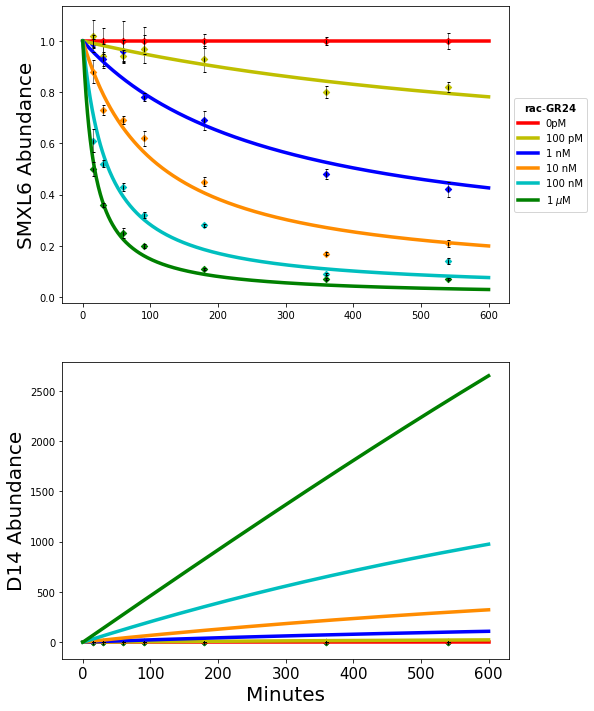

In [3]:
'''Simulation over time'''

#defining initial values


SL=0.
D14=1.
SMXL6=1.
SL_D14=0.

x0=[SL,D14,SMXL6,SL_D14]


T=np.linspace(0,600,1000)# declaring time steps





#list of corresponding treatment concentrations

realstringarray=['0pM','100 pM','1 nM','10 nM','100 nM','1 $\mu$M']




SL_x0_array=[0.,0.,0.,0.,         0.,0.]

#this list includes the 6 fitted parameters of SL_inf for the respective treatment concentrations
array=[0., 5.11370523e-02, 2.47073751e-01, 7.38526748e-01,
       2.26201278e+00, 7.98985309e+00]



colors=['r','y','b','darkorange','c','g']    #colors to connect simulations with respective data points
results=[]



fig=plt.figure(figsize=(8,12))
#simulating with different SL influxes
for j in range(len(array)):
    m.parameters['SL_inf']=array[j] #set the influx parameter


    s=Simulator(m)
    y0=np.array([SL_x0_array[j],D14,SMXL6,SL_D14])
    s.initialise(y0)

    t=np.linspace(0,600,600)
    
    s.simulate(600,steps=600)

    plt.subplot(211)
    plt.plot(s.get_time(),s.get_variable('SMXL6'),color=colors[j],label=realstringarray[j], linewidth=3.5) #plot only SMXL6 abundance
    plt.subplot(212)
    plt.plot(s.get_time(),s.get_variable('D14')+s.get_variable('SL_D14'),color=colors[j],label=realstringarray[j], linewidth=3.5)
    


#plt.legend(loc='best')    
plt.subplot(211)    
plt.ylabel('SMXL6 Abundance',fontsize=20)
#plt.title('SMXL6',fontsize=20)
plt.subplot(212)
plt.ylabel('D14 Abundance',fontsize=20)


mark='D'
linewid=0.5
S=20

#plotting the data
for i in range(len(time)):
    
    plt.subplot(211)
    plt.scatter(time[i],pm0[i],s=S,color='r',marker=mark)
    plt.errorbar(time[i],pm0[i], xerr=0., yerr=pm0_err[i],color='k',linewidth=linewid,capsize=1.5)
    plt.scatter(time[i],pm100[i],s=S,color='y',marker=mark)
    plt.errorbar(time[i],pm100[i], xerr=0., yerr=pm100_err[i],color='k',linewidth=linewid,capsize=1.5)
    
    plt.scatter(time[i],nm1[i],s=S,color='b',marker=mark)
    plt.errorbar(time[i],nm1[i], xerr=0., yerr=nm1_err[i],color='k',linewidth=linewid,capsize=1.5)
    
    plt.scatter(time[i],nm10[i],s=S,color='darkorange',marker=mark)
    plt.errorbar(time[i],nm10[i], xerr=0., yerr=nm10_err[i],color='k',linewidth=linewid,capsize=1.5)

    plt.scatter(time[i],nm100[i],s=S,color='c',marker=mark)
    plt.errorbar(time[i],nm100[i], xerr=0., yerr=nm100_err[i],color='k',linewidth=linewid,capsize=1.5)
    plt.scatter(time[i],um1[i],s=S,color='g',marker=mark)
    plt.errorbar(time[i],um1[i], xerr=0., yerr=um1_err[i],color='k',linewidth=linewid,capsize=1.5)
    

plt.legend(loc='best')
plt.legend(loc='center left', bbox_to_anchor=(1., 0.5), prop={'size': 10},title=r'$\bf{rac}$-$\bf{GR24}$')
    
    
for i in range(len(time_d14)):

    plt.subplot(212)

    plt.scatter(time_d14[i],pm0_d14[i],s=S,color='r',marker=mark)
    plt.errorbar(time_d14[i],pm0_d14[i], xerr=0., yerr=pm0_err_d14[i],color='k',linewidth=linewid,capsize=1.5)
    
    plt.scatter(time_d14[i],pm100_d14[i],s=S,color='y',marker=mark)
    plt.errorbar(time_d14[i],pm100_d14[i], xerr=0., yerr=pm100_err_d14[i],color='k',linewidth=linewid,capsize=1.5)

    plt.scatter(time_d14[i],nm1_d14[i],s=S,color='b',marker=mark)
    plt.errorbar(time_d14[i],nm1_d14[i], xerr=0., yerr=nm1_err_d14[i],color='k',linewidth=linewid,capsize=1.5)

    plt.scatter(time_d14[i],nm10_d14[i],s=S,color='darkorange',marker=mark)
    plt.errorbar(time_d14[i],nm10_d14[i], xerr=0., yerr=nm10_err_d14[i],color='k',linewidth=linewid,capsize=1.5)

    plt.scatter(time_d14[i],nm100_d14[i],s=S,color='c',marker=mark)
    plt.errorbar(time_d14[i],nm100_d14[i], xerr=0., yerr=nm100_err_d14[i],color='k',linewidth=linewid,capsize=1.5)

    plt.scatter(time_d14[i],um1_d14[i],s=S,color='g',marker=mark)
    plt.errorbar(time_d14[i],um1_d14[i], xerr=0., yerr=um1_err_d14[i],color='k',linewidth=linewid,capsize=1.5)




plt.xlabel('Minutes',fontsize=20)
#plt.yticks([0,0.5,1.],fontsize=15)
plt.xticks(fontsize=15)
#plt.xlim((-5,600))

plt.show()


Definition of an optimitation routine which returns the RMS of a parameterset after simulations. A penalty routine is included, increasing the RMS if D14 concentration is higher than 1. The optimization routine is used with the scipy.optimize.minimize function in order to return parametersets resulting in low RMS.
The resulting parameterset is used for another simulation and the results and data are plotted.

In [14]:
def penalty(x):
    #introducing a penalty function for values over 1
    if x<1:
        return 0
    else:
        return (x-1)

def optimize(p0):
    #listing and sorting data
    conc=[[1.00,	1.02,	0.99,	0.88,	0.61,	0.50],[1.00,	0.94	,0.93,	0.73,	0.52	,0.36],[1.00	,0.94,	0.96	,0.69	,0.43	,0.25],[1.00,	0.97	,0.78,	0.62,	0.32,	0.20],[1.00, 0.93 ,0.69, 0.45 ,0.28 ,0.11],[1.00,	0.80	,0.48,	0.17	,0.09,	0.07],[1.00 ,0.82 ,0.42, 0.21, 0.14 ,0.07]]
    conc=np.array(conc)


    conc_d14=[[1.00,	1.01	,0.98,	0.96	,0.93	,0.95],
              
              [1.00,1.04,0.95,0.91,0.90,0.88],
              
              [1.00,0.93,0.98,0.91,0.83,0.75],
              
              [1.00,1.07,1.06,0.98,0.84,0.74]]
    conc_d14=np.array(conc_d14)
    
    
    
    data0=[]
    data1=[]
    data2=[]
    data3=[]
    data4=[]
    data5=[]
  
    
    time=[15.,30.,60.,90.,180.,360.,540]
    time_d14=[15.,180.,360.,540]
    
    for i in range(len(time)):
        data0.append(conc[i,0])
        data1.append(conc[i,1])
        data2.append(conc[i,2])
        data3.append(conc[i,3])
        data4.append(conc[i,4])
        data5.append(conc[i,5])
        
    data0_d14=[]
    data1_d14=[]
    data2_d14=[]
    data3_d14=[]
    data4_d14=[]
    data5_d14=[]
  
    

    
    for i in range(len(time_d14)):
        data0_d14.append(conc_d14[i,0])
        data1_d14.append(conc_d14[i,1])
        data2_d14.append(conc_d14[i,2])
        data3_d14.append(conc_d14[i,3])
        data4_d14.append(conc_d14[i,4])
        data5_d14.append(conc_d14[i,5])


    #unpack parameters from p0 into corresponding dictionary keys
    inf0,inf1,inf2,inf3,inf4,inf5=p0[0:6]
    
    
    m.parameters['SL_D14_TO']=p0[6]
    m.parameters['SL_SMXL6_TO']=p0[7]
    m.parameters['SL_eff']=p0[8]
    m.parameters['SL_ka']=p0[9]
    m.parameters['SL_lm']=p0[10]
    m.parameters['recycle']=p0[11]
    

    #every SL treatment concentration, and therefore fitted SL influx, is simulated seperately
    m.parameters['SL_inf']=inf0
    s0=Simulator(m)
    y0=np.array([SL_x0_array[0],D14,SMXL6,SL_D14])
    s0.initialise(y0)
    s0.simulate(600,steps=599)
    ss0=s0.get_variable('D14')[-1]+s0.get_variable('SL_D14')[-1]
    

    
    m.parameters['SL_inf']=inf1
    s1=Simulator(m)
    y0=np.array([SL_x0_array[1],D14,SMXL6,SL_D14])
    s1.initialise(y0)
    s1.simulate(600,steps=599)
    
    
    
    ss1=s1.get_variable('D14')[-1]+s1.get_variable('SL_D14')[-1]
    
    m.parameters['SL_inf']=inf2
    s2=Simulator(m)
    y0=np.array([SL_x0_array[2],D14,SMXL6,SL_D14])
    s2.initialise(y0)
    s2.simulate(600,steps=599)
    
    ss2=s2.get_variable('D14')[-1]+s2.get_variable('SL_D14')[-1]
    
    
    m.parameters['SL_inf']=inf3
    s3=Simulator(m)
    y0=np.array([SL_x0_array[3],D14,SMXL6,SL_D14])
    s3.initialise(y0)
    s3.simulate(600,steps=599)
    ss3=s3.get_variable('D14')[-1]+s3.get_variable('SL_D14')[-1]

    m.parameters['SL_inf']=inf4
    s4=Simulator(m)
    y0=np.array([SL_x0_array[4],D14,SMXL6,SL_D14])
    s4.initialise(y0)
    s4.simulate(600,steps=599)
    ss4=s4.get_variable('D14')[-1]+s4.get_variable('SL_D14')[-1]

    m.parameters['SL_inf']=inf5
    s5=Simulator(m)
    y0=np.array([SL_x0_array[5],D14,SMXL6,SL_D14])
    s5.initialise(y0)
    s5.simulate(600,steps=599)
    ss5=s5.get_variable('D14')[-1]+s5.get_variable('SL_D14')[-1]

    # The RMS is calculated from the simulation results (using the current parameterset) and the respective data
    RSM=0
    for i in range(len(time)):


        RSM+= (data0[i]-s0.get_variable('SMXL6')[int(time[i])])**2 + (data1[i]-s1.get_variable('SMXL6')[int(time[i])])**2 + (data2[i]-s2.get_variable('SMXL6')[int(time[i])])**2 + (data3[i]-s3.get_variable('SMXL6')[int(time[i])])**2 + (data4[i]-s4.get_variable('SMXL6')[int(time[i])])**2+ (data5[i]-s5.get_variable('SMXL6')[int(time[i])])**2


    
    rootmeansquare=np.sqrt(RSM)
    
    print('rms '+str(rootmeansquare))
#    
    pen = penalty(ss0)+penalty(ss1)+penalty(ss2)+penalty(ss3)+penalty(ss4)+penalty(ss5)
#    
    score= rootmeansquare+pen
    print(rootmeansquare,pen)
    
    return score

#defining an initial guess


init_guess=[1.00000000e-03, 1.22490605e+00, 4.53390651e+00, 1.18748672e+01,
       2.68627254e+01, 4.99906913e+01, 4.04482745e+01, 1.10678975e+01,
       9.88596560e+00, 4.39116169e+01, 4.47529390e+01, 3.33665445e+01]

#defining the lower and upper bounds for all parameters

LB=0.001
UB=50

bound=((0.,UB),(LB,UB),(LB,UB),(LB,UB),(LB,UB),(LB,UB),(LB,UB),(LB,UB),(LB,UB),(LB,UB),(LB,UB),(LB,UB))

#creating a list of random parameters
randomlist=np.linspace(0.001,10,20)

#exchange parameters from the initial guess with randomly selected ones
#for i in range(len(init_guess)):
#    init_guess[i]=random.choice(randomlist)
    
#or, optionally, choose a preselected set
init_guess=[0., 0.0001 , 0.0005 , 0.0012 , 0.00175 , 0.0026,0.005,0.001,0.1,10.,0.9,0.07]

#performing a single optimization routine
fit=scipy.optimize.minimize(optimize,init_guess,bounds=bound)

rms 1.9015176592631022
1.9015176592631022 0.10105647575462795
rms 1.9015176604756399
1.9015176604756399 0.10105660892380963
rms 1.9015212368569903
1.9015212368569903 0.101056609603551
rms 1.901520238003568
1.901520238003568 0.101056609603551
rms 1.901518652989478
1.901518652989478 0.1010566085855169
rms 1.9015177029043213
1.9015177029043213 0.10105660959974272
rms 1.9015174646067472
1.9015174646067472 0.10105662218708034
rms 1.9015176593060792
1.9015176593060792 0.10105650925477505
rms 1.9015161472990578
1.9015161472990578 0.10105647575470877
rms 1.9015176014244664
1.9015176014244664 0.1010564746368614
rms 1.901517587830598
1.901517587830598 0.10105648834074699
rms 1.9015176670915679
1.9015176670915679 0.10105647575463994
rms 1.9015175682793466
1.9015175682793466 0.10105646138147728
rms 3.2278775347212934
3.2278775347212934 0.1381313327337128
rms 3.2278775347212934
3.2278775347212934 0.13813133425660928
rms 3.227877534721005
3.227877534721005 0.1381313330438121
rms 3.227877534720424
3.

rms 0.9282867743180194
0.9282867743180194 0.19670716434047364
rms 0.9282871128106404
0.9282871128106404 0.19670703638218723
rms 0.9282871575012529
0.9282871575012529 0.1967069652328357
rms 0.9282871129707665
0.9282871129707665 0.19670696500892992
rms 0.9282871664812095
0.9282871664812095 0.19670696279807198
rms 0.9282871123569675
0.9282871123569675 0.19670696524931297
rms 0.9282871213247963
0.9282871213247963 0.19670693925844396
rms 0.9104217642085649
0.9104217642085649 0.19345950344853224
rms 0.9104217642609672
0.9104217642609672 0.19345962879635192
rms 0.9104242904003573
0.9104242904003573 0.19345962845220788
rms 0.9104215803090084
0.9104215803090084 0.1934596331529772
rms 0.9104215543001836
0.9104215543001836 0.19345962749978152
rms 0.9104216220679409
0.9104216220679409 0.19345968313065098
rms 0.9104213821645208
0.9104213821645208 0.19345961996882943
rms 0.9104217640436998
0.9104217640436998 0.1934595785460751
rms 0.9104218170097772
0.9104218170097772 0.1934595026382091
rms 0.910421

rms 0.8951983204861625
0.8951983204861625 0.19545486970926773
rms 0.8951983116546489
0.8951983116546489 0.19545484370228516
rms 0.8951946458380445
0.8951946458380445 0.19545784053975424
rms 0.8951946458997071
0.8951946458997071 0.19545796380205993
rms 0.8951974862766169
0.8951974862766169 0.195457973312531
rms 0.8951946365958431
0.8951946365958431 0.195457973312531
rms 0.8951945542594695
0.8951945542594695 0.19545796855876385
rms 0.8951945759846781
0.8951945759846781 0.1954579629650628
rms 0.8951944143439292
0.8951944143439292 0.19545796293654494
rms 0.8951946457514651
0.8951946457514651 0.19545793358402475
rms 0.8951946534050977
0.8951946534050977 0.19545784053976023
rms 0.8951946342805007
0.8951946342805007 0.1954578379904779
rms 0.8951946625375864
0.8951946625375864 0.1954579029458594
rms 0.8951946467737454
0.8951946467737454 0.19545784053967807
rms 0.8951946379363473
0.8951946379363473 0.19545781453237088
rms 0.8951935861178524
0.8951935861178524 0.1954587921114075
rms 0.8951935861

rms 0.8977654312474567
0.8977654312474567 0.1411615978452272
rms 0.8977648782223948
0.8977648782223948 0.14116159814533313
rms 0.8977650619715662
0.8977650619715662 0.14116159808618622
rms 0.8977649204915196
0.8977649204915196 0.1411615980420009
rms 0.8977649915694309
0.8977649915694309 0.14116200734036832
rms 0.897764903168037
0.897764903168037 0.14116151522012022
rms 0.8977649913786367
0.8977649913786367 0.1411615150689569
rms 0.8977650061634628
0.8977650061634628 0.14116151459138004
rms 0.8977649956426751
0.8977649956426751 0.14116151521450404
rms 0.8977649527135441
0.8977649527135441 0.14116149662615474
rms 0.9075883635449133
0.9075883635449133 0.10230051665108353
rms 0.907588363633402
0.907588363633402 0.10230056617542349
rms 0.907591957291629
0.907591957291629 0.10230057530390635
rms 0.9075889199258297
0.9075889199258297 0.10230057530390635
rms 0.907588323568725
0.907588323568725 0.10230057327123254
rms 0.9075884604531171
0.9075884604531171 0.10230057629855183
rms 0.9075883113558

rms 0.8695329780083864
0.8695329780083864 0.10259508359643976
rms 0.8695329766174884
0.8695329766174884 0.10259432919564127
rms 0.8695330339711838
0.8695330339711838 0.10259432999751739
rms 0.8695330507432167
0.8695330507432167 0.1025942002166238
rms 0.8695329799014769
0.8695329799014769 0.10259432927668088
rms 0.8695329671689469
0.8695329671689469 0.10259431602918556
rms 0.8695580436360577
0.8695580436360577 0.10254883487542354
rms 0.8695580436935829
0.8695580436935829 0.10254889210247531
rms 0.8695607779334393
0.8695607779334393 0.10254889262787747
rms 0.8695581193405217
0.8695581193405217 0.10254889245275
rms 0.869557909268756
0.869557909268756 0.10254889792849409
rms 0.869558004981309
0.869558004981309 0.10254889263315814
rms 0.8695579198995893
0.8695579198995893 0.10254889766216047
rms 0.8695580431863995
0.8695580431863995 0.10254958888283405
rms 0.8695580417337759
0.8695580417337759 0.10254883486957334
rms 0.8695580434483695
0.8695580434483695 0.10254883459199893
rms 0.8695580341

rms 0.8647814817503794
0.8647814817503794 0.10479498947947907
rms 0.8644282147004734
0.8644282147004734 0.10489662340630646
rms 0.8644282147548186
0.8644282147548186 0.10489668611814307
rms 0.864430871626979
0.864430871626979 0.10489668128568641
rms 0.8644281749568249
0.8644281749568249 0.1048966809344063
rms 0.86442818586115
0.86442818586115 0.10489668092029181
rms 0.8644281892521447
0.8644281892521447 0.10489681052198208
rms 0.8644280838739865
0.8644280838739865 0.10489667630562338
rms 0.8644282142197778
0.8644282142197778 0.10489739466016568
rms 0.8644282153006726
0.8644282153006726 0.10489662340581285
rms 0.8644282548180232
0.8644282548180232 0.10489662133951638
rms 0.8644283014286207
0.8644283014286207 0.10489674914691016
rms 0.8644282160662433
0.8644282160662433 0.10489662340418016
rms 0.8644282046890823
0.8644282046890823 0.10489660990609817
rms 0.8631671831744266
0.8631671831744266 0.10530282543011116
rms 0.8631671832278199
0.8631671832278199 0.10530288714875957
rms 0.863169804

rms 0.8524268770940424
0.8524268770940424 0.11126296727868845
rms 0.8524268692907333
0.8524268692907333 0.1112629689182203
rms 0.8524268884022181
0.8524268884022181 0.11126294240832912
rms 0.8524269224384718
0.8524269224384718 0.11126296714934547
rms 0.8524269808424042
0.8524269808424042 0.11126372848013655
rms 0.8524269901526222
0.8524269901526222 0.11126291063298699
rms 0.8524269812503626
0.8524269812503626 0.11126291031362712
rms 0.8524269871402753
0.8524269871402753 0.1112629955258091
rms 0.8524269825305337
0.8524269825305337 0.11126291043467806
rms 0.8524269746817231
0.8524269746817231 0.11126289655550003
rms 0.8521585025777975
0.8521585025777975 0.11150798691905739
rms 0.8521585026276963
0.8521585026276963 0.11150804748618603
rms 0.8521609176452367
0.8521609176452367 0.11150804276534498
rms 0.8521583719992959
0.8521583719992959 0.1115080479380317
rms 0.8521584225803469
0.8521584225803469 0.11150804615809151
rms 0.8521584065041874
0.8521584065041874 0.111508043818759
rms 0.8521584

rms 0.8518388086670956
0.8518388086670956 0.11221808957696577
rms 0.8518388774370776
0.8518388774370776 0.11221809744442646
rms 0.8518388463696801
0.8518388463696801 0.11221809306406905
rms 0.8518388322677717
0.8518388322677717 0.11221807880809198
rms 0.8518819018991636
0.8518819018991636 0.11167449879691138
rms 0.8518819019491756
0.8518819019491756 0.11167455995617459
rms 0.851884399826389
0.851884399826389 0.11167455653108904
rms 0.8518818467369134
0.8518818467369134 0.11167455557581629
rms 0.8518818739551788
0.8518818739551788 0.11167450339270446
rms 0.8518818152673813
0.8518818152673813 0.1116745519115998
rms 0.8518818648190537
0.8518818648190537 0.11167456813398946
rms 0.8518819013904421
0.8518819013904421 0.11167531983970092
rms 0.851881905781559
0.851881905781559 0.11167449879543234
rms 0.8518819269353731
0.8518819269353731 0.1116745031418751
rms 0.8518819654211773
0.8518819654211773 0.11167449674515462
rms 0.8518819032621918
0.8518819032621918 0.11167449879704439
rms 0.85188189

rms 0.8518817786398598
0.8518817786398598 0.11167462175560394
rms 0.8518817786898721
0.8518817786898721 0.11167468291566518
rms 0.8518842376559485
0.8518842376559485 0.11167467852872726
rms 0.8518817097555831
0.8518817097555831 0.11167468204530806
rms 0.8518817157399478
0.8518817157399478 0.11167472817877
rms 0.8518816279108731
0.8518816279108731 0.11167468938934055
rms 0.8518817226158953
0.8518817226158953 0.11167467619295768
rms 0.8518817781353228
0.8518817781353228 0.11167544279911645
rms 0.8518817825811332
0.8518817825811332 0.11167462175651033
rms 0.8518817785462551
0.8518817785462551 0.11167462163839503
rms 0.8518817897489257
0.8518817897489257 0.11167462698236919
rms 0.8518817800554241
0.8518817800554241 0.11167462175627674
rms 0.8518817701667938
0.8518817701667938 0.11167460757186154


In [25]:
%matplotlib qt
realstringarray=['0 pM','100 pM','1 nM','10 nM','100 nM','1 $\mu$M']

#unpacking and plotting simulation results with the resulting fitted parameter set
m.parameters['SL_D14_TO']=fit.x[6]
m.parameters['SL_SMXL6_TO']=fit.x[7]
m.parameters['SL_eff']=fit.x[8]
m.parameters['SL_ka']=fit.x[9]
m.parameters['SL_lm']=fit.x[10]
m.parameters['recycle']=fit.x[11]

cnt=0
for j in fit.x[0:6]:
    m.parameters['SL_inf']=j #set the influx parameter


    s=Simulator(m)
    y0=np.array([SL_x0_array[cnt],D14,SMXL6,SL_D14])
    s.initialise(y0)

    t=np.linspace(0,600,600)
    
    s.simulate(600,steps=600)
    
    
    
    plt.subplot(211)
    plt.plot(s.get_time(),s.get_variable('SMXL6'),color=colors[cnt],label=realstringarray[cnt], linewidth=3.5) #plot only SMXL6 abundance
    plt.subplot(212)
    plt.plot(s.get_time(),s.get_variable('D14')+s.get_variable('SL_D14'),color=colors[cnt],label=realstringarray[cnt], linewidth=3.5)
    cnt+=1


plt.subplot(211)    
plt.ylabel('SMXL6 Abundance',fontsize=20)
#plt.title('SMXL6',fontsize=20)
plt.subplot(212)
plt.ylabel('D14 Abundance',fontsize=20)


mark='D'
linewid=0.5
S=20


for i in range(len(time)):
    
    plt.subplot(211)
    plt.scatter(time[i],pm0[i],s=S,color='r',marker=mark)
    plt.errorbar(time[i],pm0[i], xerr=0., yerr=pm0_err[i],color='k',linewidth=linewid,capsize=1.5)
    plt.scatter(time[i],pm100[i],s=S,color='y',marker=mark)
    plt.errorbar(time[i],pm100[i], xerr=0., yerr=pm100_err[i],color='k',linewidth=linewid,capsize=1.5)
    
    plt.scatter(time[i],nm1[i],s=S,color='b',marker=mark)
    plt.errorbar(time[i],nm1[i], xerr=0., yerr=nm1_err[i],color='k',linewidth=linewid,capsize=1.5)
    
    plt.scatter(time[i],nm10[i],s=S,color='darkorange',marker=mark)
    plt.errorbar(time[i],nm10[i], xerr=0., yerr=nm10_err[i],color='k',linewidth=linewid,capsize=1.5)

    plt.scatter(time[i],nm100[i],s=S,color='c',marker=mark)
    plt.errorbar(time[i],nm100[i], xerr=0., yerr=nm100_err[i],color='k',linewidth=linewid,capsize=1.5)
    plt.scatter(time[i],um1[i],s=S,color='g',marker=mark)
    plt.errorbar(time[i],um1[i], xerr=0., yerr=um1_err[i],color='k',linewidth=linewid,capsize=1.5)
    

plt.legend(loc='best')
plt.legend(loc='center left', bbox_to_anchor=(1., 0.5), prop={'size': 10},title=r'$\bf{rac}$-$\bf{GR24}$')

    
for i in range(len(time_d14)):

    plt.subplot(212)

    plt.scatter(time_d14[i],pm0_d14[i],s=S,color='r',marker=mark)
    plt.errorbar(time_d14[i],pm0_d14[i], xerr=0., yerr=pm0_err_d14[i],color='k',linewidth=linewid,capsize=1.5)
    
    plt.scatter(time_d14[i],pm100_d14[i],s=S,color='y',marker=mark)
    plt.errorbar(time_d14[i],pm100_d14[i], xerr=0., yerr=pm100_err_d14[i],color='k',linewidth=linewid,capsize=1.5)

    plt.scatter(time_d14[i],nm1_d14[i],s=S,color='b',marker=mark)
    plt.errorbar(time_d14[i],nm1_d14[i], xerr=0., yerr=nm1_err_d14[i],color='k',linewidth=linewid,capsize=1.5)

    plt.scatter(time_d14[i],nm10_d14[i],s=S,color='darkorange',marker=mark)
    plt.errorbar(time_d14[i],nm10_d14[i], xerr=0., yerr=nm10_err_d14[i],color='k',linewidth=linewid,capsize=1.5)

    plt.scatter(time_d14[i],nm100_d14[i],s=S,color='c',marker=mark)
    plt.errorbar(time_d14[i],nm100_d14[i], xerr=0., yerr=nm100_err_d14[i],color='k',linewidth=linewid,capsize=1.5)

    plt.scatter(time_d14[i],um1_d14[i],s=S,color='g',marker=mark)
    plt.errorbar(time_d14[i],um1_d14[i], xerr=0., yerr=um1_err_d14[i],color='k',linewidth=linewid,capsize=1.5)




plt.xlabel('Minutes',fontsize=20)
plt.yticks([0,0.5,1.],fontsize=15)
plt.xticks(fontsize=15)
#plt.xlim((-5,600))

plt.show()
#fig.savefig('SMXL6_plot_supp', bbox_inches='tight')






In [ ]:
m.parameters

In order to avoid local optima, the optimization routine is used 500 times with random parameters. A random seed is used in order to ensure reproducibility. The resulting RMS and parameterset are captured in lists and plotted for evaluation.

In [ ]:
#defining lists to capture results
big_speicher=[]
speicher=[]
funs=[]
#defining random seed for reproducibility
np.random.seed(0)
#performing 500 optimizations using randomly selected initial guesses
for n in range(500):
    randomlist=np.linspace(0.001,10,20)
    
    
    for i in range(len(init_guess)):
        init_guess[i]=random.choice(randomlist)
        

    fit=scipy.optimize.minimize(optimize,init_guess,bounds=bound)
    
    big_speicher.append(fit.x)
    funs.append(fit.fun)





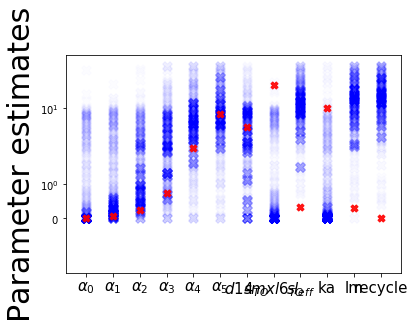

In [4]:


import pickle
speicher=pickle.load( open( "parameter_scans/WEfitoldsl.p", "rb" ) )
funz=pickle.load( open( "parameter_scans/WEfitoldslfuns.p", "rb" ) )







#visualizing the results of the parameter scan
fig=plt.figure()
ax= fig.add_subplot(111)

parnames=[r'$\alpha_0$',r'$\alpha_1$',r'$\alpha_2$',r'$\alpha_3$',r'$\alpha_4$',r'$\alpha_5$', r'$d14_{TO}$',r'$smxl6_{TO}$',r'$sl_{eff}$','ka','lm','recycle']#,r'$d14_{deg}$']



mypars=[0., 5.11370523e-02, 2.47073751e-01, 7.38526748e-01,
        2.26201278e+00, 7.98985309e+00, 4.86439696e+00,2.47686667e+01,3.18236927e-01,1.00057740e+01, 3.08892044e-01,1.00000000e-03]


#adjusting transparency for parametersets with RMS above/under 0.45
for i in range(len(speicher)):
    if funz[i]>0.45:
        ax.scatter(parnames,speicher[i],s=100,color='b',marker='X',alpha=0.01)
    else:
        ax.scatter(parnames,speicher[i],s=100,color='b',marker='X',alpha=0.3)
        
    
    
    
ax.tick_params('x',labelsize=15.)
plt.scatter(parnames,mypars,s=50,color='r',marker='X',alpha=0.9)
plt.yscale('symlog')
plt.ylabel('Parameter estimates',fontsize=30)
#plt.ylim((0.,10e02))
plt.show()


